In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.signal import find_peaks
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score
from matplotlib.pyplot import figure
import matplotlib
from funcs import getStatsMetrics, getHistSignalPlot, getSpikesPlot

matplotlib.rc('figure', figsize=(18, 4))

# Carga de Datos del archivo GABA

In [7]:
data = pd.read_csv('TrozoG.txt', delimiter='\t', header=None, skiprows = range(3), decimal = ",", index_col = False)

In [8]:
print(len(data))
data.drop(columns=[3], inplace=True)
data.columns = ['LP','VD','GABA']
data = data.apply(pd.to_numeric)
data['Time'] = data.index
print(data.head())

16384000
         LP        VD      GABA  Time
0 -0.006104  0.064697  0.120239     0
1 -0.004272  0.075989  0.126343     1
2 -0.003357  0.087280  0.125427     2
3 -0.005188  0.092468  0.123596     3
4 -0.007324  0.093384  0.118713     4


In [9]:
data.dropna(axis=0, how='any',inplace=True)
data.isnull().sum()

LP      0
VD      0
GABA    0
Time    0
dtype: int64

In [10]:
data.describe()

,LP,VD,GABA,Time
count,1.638400e+07,1.638400e+07,1.638400e+07,1.638400e+07
mean,1.782227e-11,4.330900e-02,1.361662e-01,8.192000e+06
std,8.109792e-02,3.337760e-02,2.849763e-01,4.729654e+06
min,-6.420900e-01,-3.088380e-01,-5.462600e-02,0.000000e+00
25%,-2.624500e-02,3.326400e-02,1.141360e-01,4.096000e+06
50%,0.000000e+00,4.303000e-02,1.199340e-01,8.192000e+06
75%,2.441400e-02,5.310100e-02,1.260380e-01,1.228800e+07
max,9.265140e-01,5.520630e-01,5.220642e+00,1.638400e+07


# Cálculo del umbral

In [11]:
dist_sd=4

lp_mean,lp_sd,low_lp,high_lp = getStatsMetrics(data.LP, dist_sd)
print('LP:\n\tMean: %f\n\tSD: %f\n\tLow: %f\n\tHigh: %f'%(lp_mean,lp_sd,low_lp,high_lp))

vd_mean,vd_sd,low_vd,high_vd = getStatsMetrics(data.VD, dist_sd)
print('VD:\n\tMean: %f\n\tSD: %f\n\tLow: %f\n\tHigh: %f'%(vd_mean,vd_sd,low_vd,high_vd))

ga_mean,ga_sd,low_ga,high_ga = getStatsMetrics(data.GABA, dist_sd)
print('GABA:\n\tMean: %f\n\tSD: %f\n\tLow: %f\n\tHigh: %f'%(ga_mean,ga_sd,low_ga,high_ga))

LP:
	Mean: 0.000000
	SD: 0.081098
	Low: -0.324392
	High: 0.324392
VD:
	Mean: 0.043309
	SD: 0.033378
	Low: -0.090201
	High: 0.176819
GABA:
	Mean: 0.136166
	SD: 0.284976
	Low: -1.003739
	High: 1.276072


# Visualización del histograma de la señal y el umbral escogido

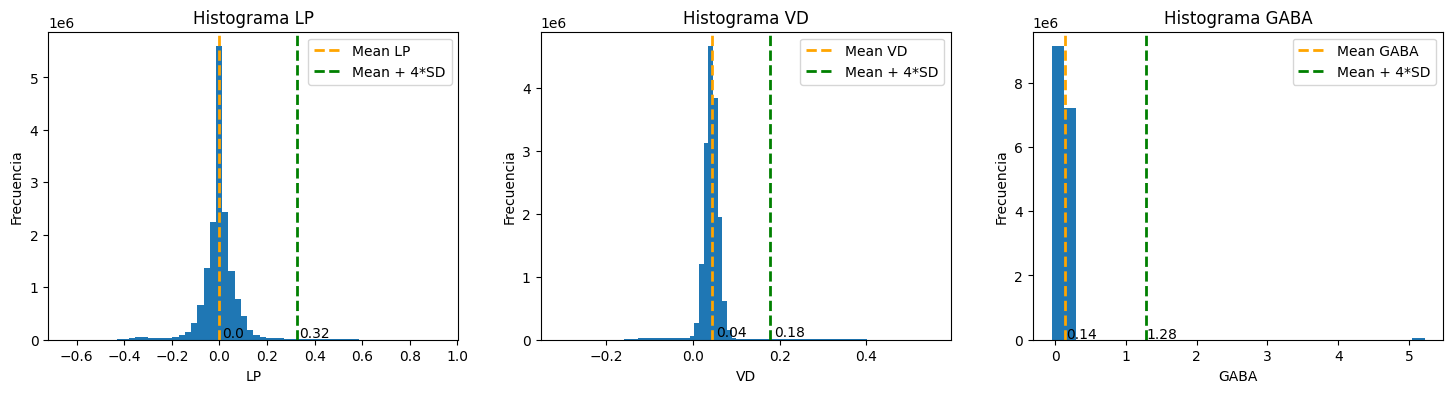

In [12]:
plt.subplot(1,3,1)
getHistSignalPlot(data.LP,lp_mean,low_lp,high_lp, dist_sd, 'LP', bins=60)

plt.subplot(1,3,2)
getHistSignalPlot(data.VD,vd_mean,low_vd,high_vd, dist_sd, 'VD', bins=80)

plt.subplot(1,3,3)
getHistSignalPlot(data.GABA,ga_mean,low_ga,high_ga, dist_sd, 'GABA', bins=30)

# Codificación de los spikes

In [13]:
spikes_lp = find_peaks(data['LP'])[0]
spikes_vd = find_peaks(data['VD'])[0]
spikes_ga = find_peaks(data['GABA'])[0]


lp_sp_data = pd.DataFrame(data = {'Time':spikes_lp,'ValueLP':data['LP'][spikes_lp],'IsSpikeLP' : 1})
lp_sp_data = lp_sp_data[lp_sp_data['ValueLP'] >= high_lp]

vd_sp_data = pd.DataFrame(data = {'Time':spikes_vd,'ValueVD':data['VD'][spikes_vd],'IsSpikeVD' : 1})
vd_sp_data = vd_sp_data[vd_sp_data['ValueVD'] >= high_vd]

ga_sp_data = pd.DataFrame(data = {'Time':spikes_ga,'ValueGABA':data['GABA'][spikes_ga],'IsSpikeGABA' : 1})
ga_sp_data = ga_sp_data[ga_sp_data['ValueGABA'] >= high_vd]



In [14]:
data = pd.merge(data, lp_sp_data, on = 'Time', how='left')
data = pd.merge(data, vd_sp_data, on = 'Time', how='left')
data = pd.merge(data, ga_sp_data, on = 'Time', how='left')
data['IsSpikeLP'].fillna(0, inplace=True)
data['IsSpikeVD'].fillna(0, inplace=True)
data['IsSpikeGABA'].fillna(0, inplace=True)


In [15]:
data.head()

,LP,VD,GABA,Time,ValueLP,IsSpikeLP,ValueVD,IsSpikeVD,ValueGABA,IsSpikeGABA
0,-0.006104,0.064697,0.120239,0,NaN,0.0,NaN,0.0,NaN,0.0
1,-0.004272,0.075989,0.126343,1,NaN,0.0,NaN,0.0,NaN,0.0
2,-0.003357,0.087280,0.125427,2,NaN,0.0,NaN,0.0,NaN,0.0
3,-0.005188,0.092468,0.123596,3,NaN,0.0,NaN,0.0,NaN,0.0
4,-0.007324,0.093384,0.118713,4,NaN,0.0,NaN,0.0,NaN,0.0


# Visualización de los spikes en la señal

c:\Users\marlo\OneDrive - UAM\Master Data Science\1er Semestre\Teoria de Informacion\PracticaTI\funcs.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2.loc[:,'breaks'] = np.repeat(breaks,break_size)[0:data_end-data_init]
c:\Users\marlo\OneDrive - UAM\Master Data Science\1er Semestre\Teoria de Informacion\PracticaTI\funcs.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2.loc[:,'breaks'] = np.repeat(breaks,break_size)[0:data_end-data_init]
c:\Users\marlo\OneDrive - UAM\Master Data Science\1e

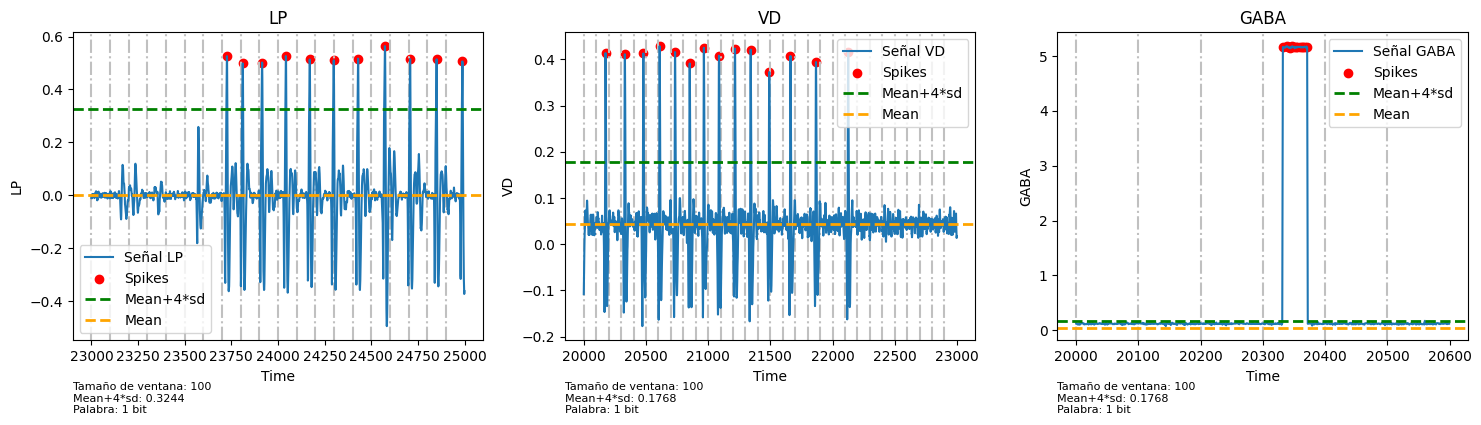

In [16]:
plt.subplot(1,3,1)
getSpikesPlot(data, 100, 23000, 25000,high_lp,lp_mean, 'LP')

plt.subplot(1,3,2)
getSpikesPlot(data, 100, 20000, 23000,high_vd, vd_mean, 'VD')

plt.subplot(1,3,3)
getSpikesPlot(data, 100, 20000, 20600,high_vd, vd_mean, 'GABA')

# Agrupación por tamaño de palabra o bit

In [17]:
for p in range(1,9):
    palabra = p
    breaks = np.arange(0,len(data),palabra)
    data.loc[:,'W'+str(p)] = np.repeat(breaks,palabra)[0:len(data)]

data.head()

,LP,VD,GABA,Time,ValueLP,IsSpikeLP,ValueVD,IsSpikeVD,ValueGABA,IsSpikeGABA,W1,W2,W3,W4,W5,W6,W7,W8
0,-0.006104,0.064697,0.120239,0,NaN,0.0,NaN,0.0,NaN,0.0,0,0,0,0,0,0,0,0
1,-0.004272,0.075989,0.126343,1,NaN,0.0,NaN,0.0,NaN,0.0,1,0,0,0,0,0,0,0
2,-0.003357,0.087280,0.125427,2,NaN,0.0,NaN,0.0,NaN,0.0,2,2,0,0,0,0,0,0
3,-0.005188,0.092468,0.123596,3,NaN,0.0,NaN,0.0,NaN,0.0,3,2,3,0,0,0,0,0
4,-0.007324,0.093384,0.118713,4,NaN,0.0,NaN,0.0,NaN,0.0,4,4,3,4,0,0,0,0


In [18]:
data_palabras = list()

for i in data.columns[list(data.columns).index('W1'):len(data.columns)]:
    d = data.groupby(i)[['IsSpikeLP','IsSpikeVD', 'IsSpikeGABA']].agg('sum').reset_index()
    d['IsSpikeLP'] = d['IsSpikeLP'] > 0
    d['IsSpikeVD'] = d['IsSpikeVD'] > 0
    d['IsSpikeGABA'] = d['IsSpikeGABA'] > 0
    data_palabras.append(d)

    print('Tamaño de Palabra: %s\nDimensión dataframe: %s'%(str(i),str(d.shape)))
    print(d.head(3))
    print('\n')

Tamaño de Palabra: W1
Dimensión dataframe: (16384000, 4)
   W1  IsSpikeLP  IsSpikeVD  IsSpikeGABA
0   0      False      False        False
1   1      False      False        False
2   2      False      False        False


Tamaño de Palabra: W2
Dimensión dataframe: (8192000, 4)
   W2  IsSpikeLP  IsSpikeVD  IsSpikeGABA
0   0      False      False        False
1   2      False      False        False
2   4      False      False        False


Tamaño de Palabra: W3
Dimensión dataframe: (5461334, 4)
   W3  IsSpikeLP  IsSpikeVD  IsSpikeGABA
0   0      False      False        False
1   3      False      False        False
2   6      False      False        False


Tamaño de Palabra: W4
Dimensión dataframe: (4096000, 4)
   W4  IsSpikeLP  IsSpikeVD  IsSpikeGABA
0   0      False      False        False
1   4      False      False        False
2   8      False      False        False


Tamaño de Palabra: W5
Dimensión dataframe: (3276800, 4)
   W5  IsSpikeLP  IsSpikeVD  IsSpikeGABA
0   0      Fal

# Cálculo de Entropía, MI y Error para distintos tamaños de ventana y palabra

In [19]:
window_sizes_w = np.arange(5,600,10)
df_w_metrics = {}

for df_w in data_palabras:
    df_w_MI = []
    df_w_MI_lp_ga_norm = []
    df_w_MI_vd_ga_norm = []
    
    df_w_MI_norm = []
    df_w_E_lp = []
    df_w_E_vd = []
    df_w_E_ga = []
    df_entropy_lp_a_vd = []
    df_entropy_vd_a_lp = []

    for win_size in window_sizes_w:
        breaks = np.arange(0,len(df_w),win_size)
        d = df_w
        d.loc[:,'breaks'] = np.repeat(breaks,win_size)[0:len(d)]
        d = d.groupby('breaks')[['IsSpikeLP','IsSpikeVD','IsSpikeGABA']].agg('sum').reset_index()
        d['ErrorsLP'] = d['IsSpikeLP'] > 1
        d['ErrorsVD'] = d['IsSpikeVD'] > 1
        d['ErrorsGABA'] = d['IsSpikeGABA'] > 1
        df_w_E_lp.append(sum(d['ErrorsLP'])/len(d)*100)
        df_w_E_vd.append(sum(d['ErrorsVD'])/len(d)*100)
        df_w_E_ga.append(sum(d['ErrorsGABA'])/len(d)*100)

        MI = mutual_info_score(d['IsSpikeLP'], d['IsSpikeVD'])
        MI_norm = mutual_info_score(d['IsSpikeLP'], d['IsSpikeVD'])/(win_size*int(df_w.columns[0][1]))
        df_w_MI_lp_ga_norm = mutual_info_score(d['IsSpikeLP'], d['IsSpikeGABA'])/(win_size*int(df_w.columns[0][1]))
        df_w_MI_vd_ga_norm = mutual_info_score(d['IsSpikeVD'], d['IsSpikeGABA'])/(win_size*int(df_w.columns[0][1]))

        Slp = stats.entropy(d['IsSpikeLP'])
        Svd = stats.entropy(d['IsSpikeVD'])

        df_w_MI.append(MI) 
        df_w_MI_norm.append(MI_norm)   
        df_entropy_lp_a_vd.append(MI/Svd)
        df_entropy_vd_a_lp.append(MI/Slp)

    df_w_m = pd.DataFrame({'WindSize':window_sizes_w, 'ErrorLP':df_w_E_lp, 'ErrorVD':df_w_E_vd, 'ErrorGABA':  df_w_E_ga,
                           'MI':df_w_MI, 'MI_norm':df_w_MI_norm, 'MI_norm_lp_ga': df_w_MI_lp_ga_norm, 
                           'MI_norm_vd_ga': df_w_MI_vd_ga_norm,
                           'Slp_vd':df_entropy_lp_a_vd,'Svd_lp':df_entropy_vd_a_lp})
    df_w_metrics[df_w.columns[0]]  = df_w_m




In [20]:
df_w_metrics['W1'].head()

,WindSize,ErrorLP,ErrorVD,ErrorGABA,MI,MI_norm,MI_norm_lp_ga,MI_norm_vd_ga,Slp_vd,Svd_lp
0,5,0.000031,0.000000,0.178558,0.000027,0.000005,0.000026,0.000155,0.000003,0.000003
1,15,0.000732,0.000092,0.371338,0.000255,0.000017,0.000026,0.000155,0.000026,0.000025
2,25,0.001526,0.000153,0.455780,0.000740,0.000030,0.000026,0.000155,0.000077,0.000072
3,35,0.008331,0.000214,0.533202,0.001402,0.000040,0.000026,0.000155,0.000145,0.000137
4,45,0.015930,0.000275,0.618530,0.002333,0.000052,0.000026,0.000155,0.000242,0.000229


# Visualización del Error

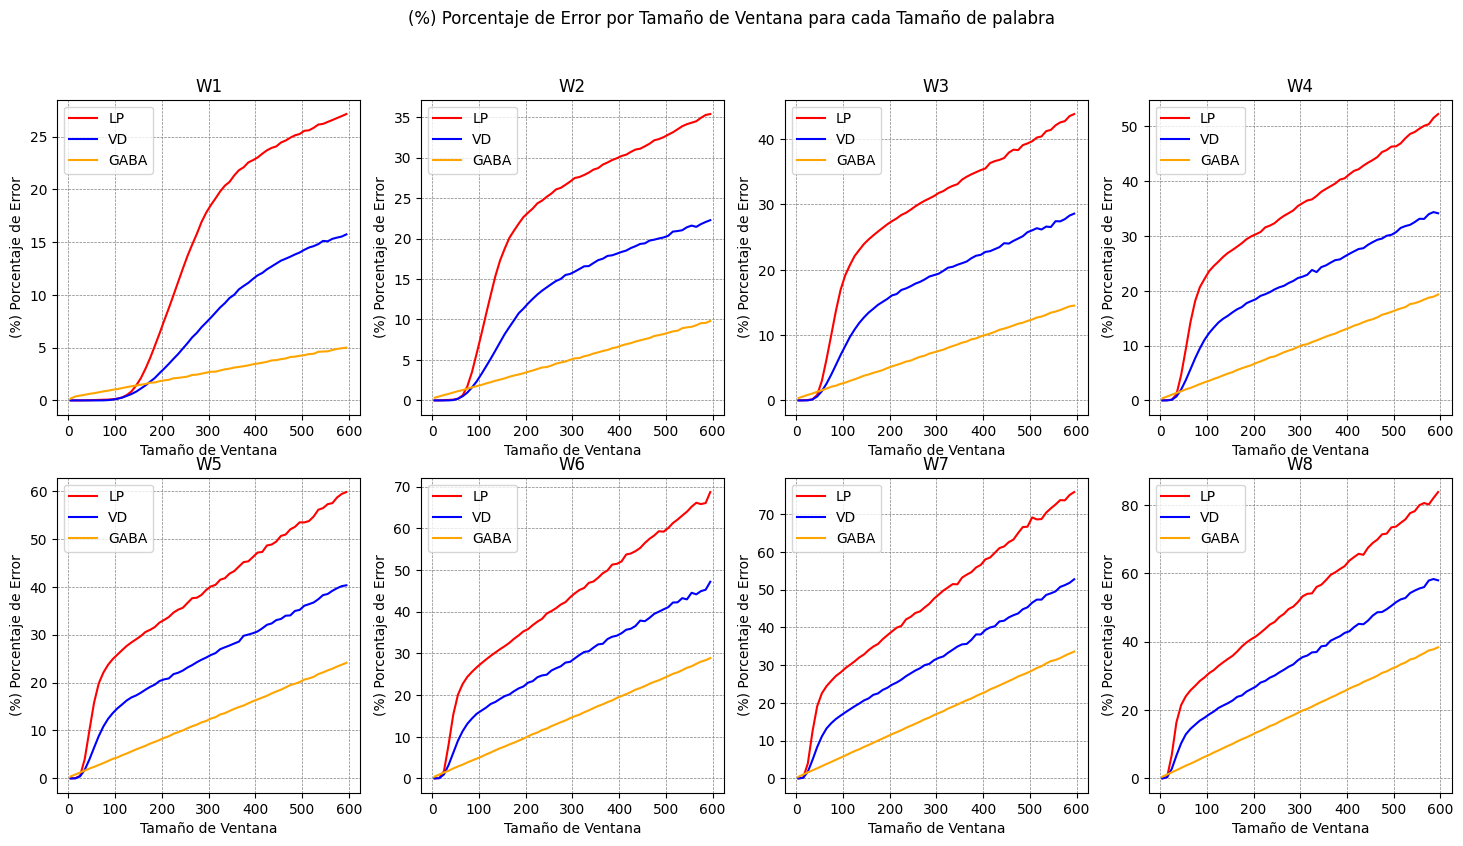

In [21]:
n_rows = 2
n_cols = 4
keys = [key for key in df_w_metrics]

fig, axs = plt.subplots(n_rows, n_cols)
n_plots = 0
fig.suptitle('(%) Porcentaje de Error por Tamaño de Ventana para cada Tamaño de palabra')
for r in range(n_rows):
    for c in range(n_cols):
        df = df_w_metrics[keys[n_plots]]

        axs[r, c].plot(df['WindSize'], df['ErrorLP'],color = 'red', label = 'LP')
        axs[r, c].plot(df['WindSize'], df['ErrorVD'],color = 'blue', label = 'VD')
        axs[r, c].plot(df['WindSize'], df['ErrorGABA'],color = 'orange', label = 'GABA')
        axs[r, c].set_title(keys[n_plots])
        axs[r, c].grid(color = 'gray', linestyle = '--', linewidth = 0.5)
        axs[r, c].legend()


        n_plots+=1

for ax in axs.flat:
    ax.set(xlabel='Tamaño de Ventana', ylabel='(%) Porcentaje de Error')

fig.set_size_inches(18, 9)


# Visualización de la Información Mutua Normalizada por Tamaño de Ventana y Palabra

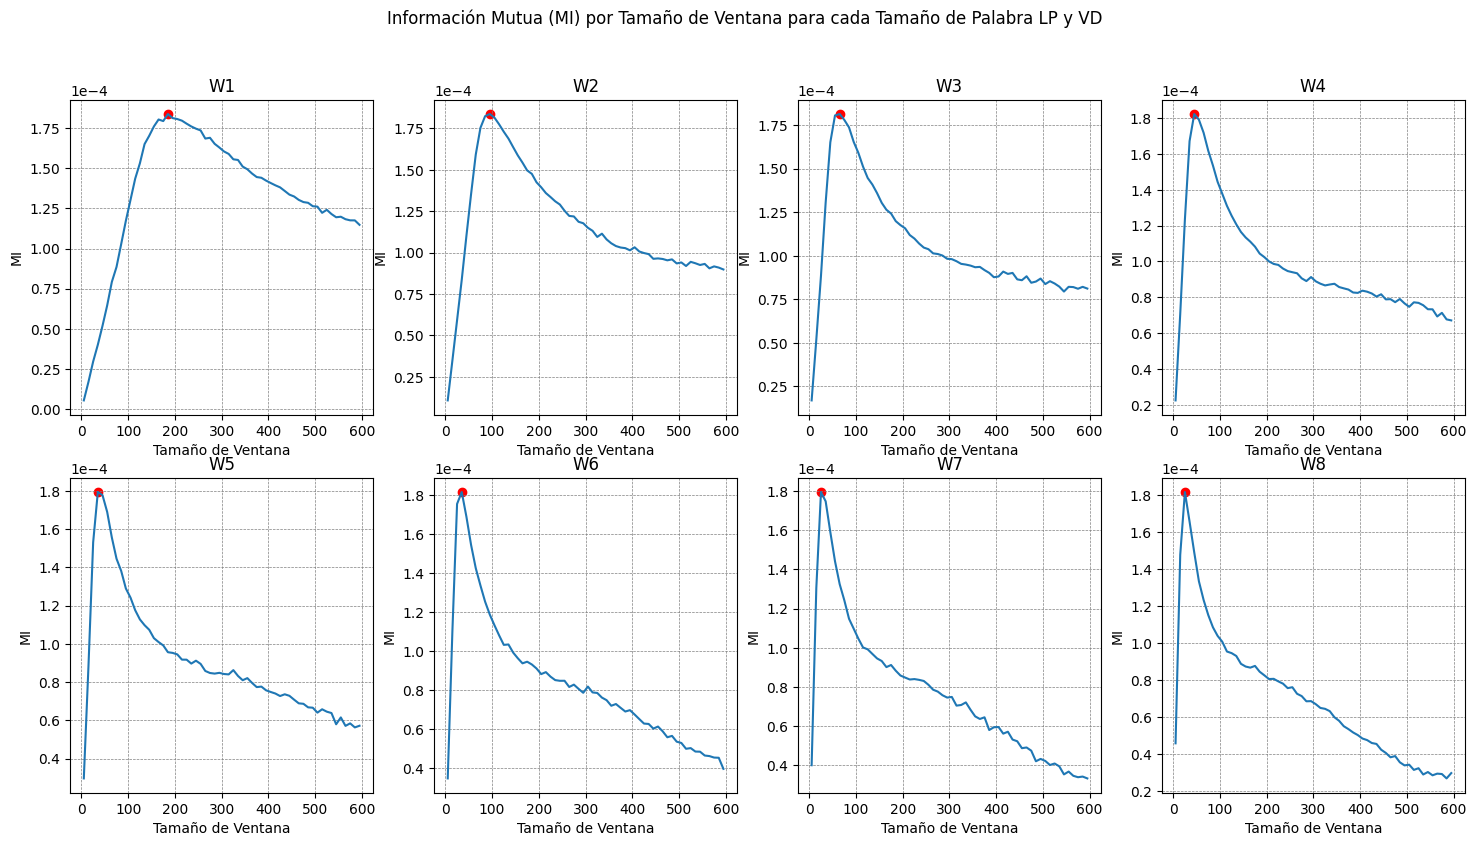

In [22]:
n_cols = 4
keys = [key for key in df_w_metrics]

fig, axs = plt.subplots(n_rows, n_cols)
n_plots = 0
fig.suptitle('Información Mutua (MI) por Tamaño de Ventana para cada Tamaño de Palabra LP y VD')
best_wind = []
best_MI = []
for r in range(n_rows):
    for c in range(n_cols):
        df = df_w_metrics[keys[n_plots]]

        max_val = list(df['MI_norm']).index(max(df['MI_norm']))
        x_max_val = df['WindSize'][max_val]
        y_max_val = df['MI_norm'][max_val]

        best_wind.append(df['WindSize'][max_val])
        best_MI.append(y_max_val)

        axs[r, c].plot(df['WindSize'], df['MI_norm'])
        axs[r, c].scatter(x_max_val, y_max_val, c = 'r')
        axs[r, c].set_title(keys[n_plots])
        axs[r, c].grid(color = 'gray', linestyle = '--', linewidth = 0.5)
        axs[r, c].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

        n_plots+=1

for ax in axs.flat:
    ax.set(xlabel='Tamaño de Ventana', ylabel='MI')

# for ax in axs.flat:
#     ax.label_outer()

fig.set_size_inches(18, 9)

In [23]:
# df_wind_inf = pd.DataFrame({'bits':np.arange(1,9),'WindSize':best_wind, 'best_MI':best_MI})
# df_wind_inf.sort_values(by='best_MI', ascending=False, inplace=True)
# print(df_wind_inf.to_latex(index=False,formatters={"name": str.upper}))

# Visualización Trasferencia de Entropía

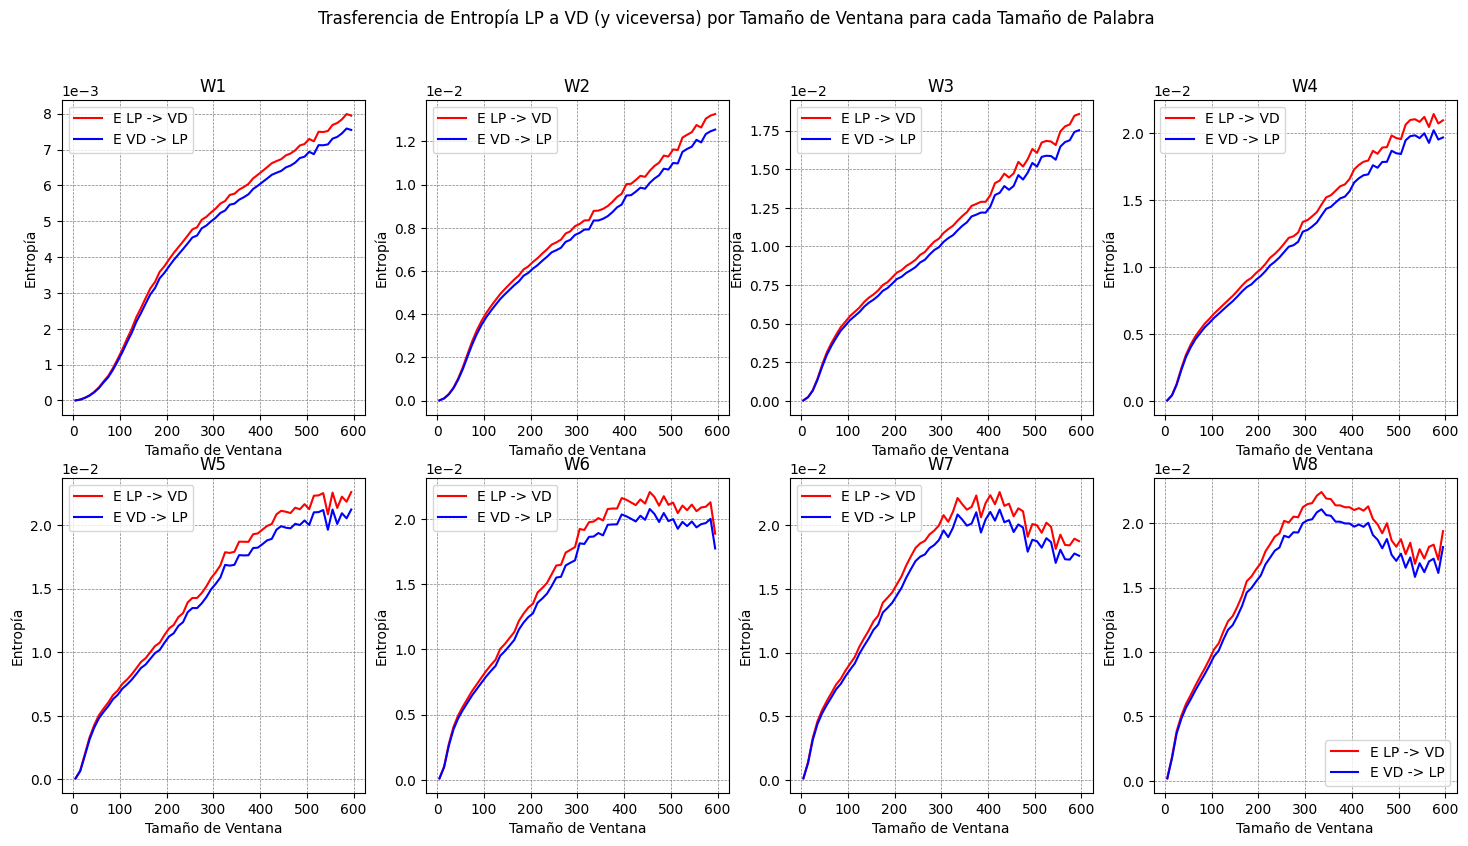

In [24]:
n_cols = 4
keys = [key for key in df_w_metrics]

fig, axs = plt.subplots(n_rows, n_cols)
n_plots = 0
fig.suptitle('Trasferencia de Entropía LP a VD (y viceversa) por Tamaño de Ventana para cada Tamaño de Palabra')
for r in range(n_rows):
    for c in range(n_cols):
        df = df_w_metrics[keys[n_plots]]

        axs[r, c].plot(df['WindSize'], df['Slp_vd'],color = 'red', label = 'E LP -> VD')
        axs[r, c].plot(df['WindSize'], df['Svd_lp'],color = 'blue', label = 'E VD -> LP')
        axs[r, c].set_title(keys[n_plots])
        axs[r, c].grid(color = 'gray', linestyle = '--', linewidth = 0.5)
        axs[r, c].legend()
        axs[r, c].ticklabel_format(style='sci', axis='y', scilimits=(0,0))


        n_plots+=1

for ax in axs.flat:
    ax.set(xlabel='Tamaño de Ventana', ylabel='Entropía')

fig.set_size_inches(18, 9)